## 15/11/2024

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scvi
import os
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=float32,force_device=True'
import cell2location
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
import seaborn as sns
import time
import gc
import tarfile

/home/okwong/miniconda3/envs/ML/lib/python3.12/site-packages/anndata-0.11.0rc3-py3.12.egg/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/okwong/miniconda3/envs/ML/lib/python3.12/site-packages/anndata-0.11.0rc3-py3.12.egg/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/okwong/miniconda3/envs/ML/lib/python3.12/site-packages/anndata-0.11.0rc3-py3.12.egg/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/okwong/miniconda3/envs/ML/lib/python3.12/site-packages/anndata-0.11.0rc3-py3.12.egg/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, F

In [3]:
DATA_DIR = '/autofs/bal34/okwong/human_PBMC_ref/files'

In [45]:
# loading all data into scanpy

import os
import scanpy as sc
import pandas as pd

# Initialize empty lists to store the data
barcodes_list = []
features_list = []
matrix_list = []

# Loop through the files in the directory
for file_name in os.listdir(DATA_DIR):
    if file_name.endswith("barcodes.tsv.gz"):
        barcodes_list.append(file_name)
    elif file_name.endswith("features.tsv.gz"):
        features_list.append(file_name)
    elif file_name.endswith("matrix.mtx.gz"):
        matrix_list.append(file_name)

# Sort the lists
barcodes_list.sort()
features_list.sort()
matrix_list.sort()

# Initialize an empty AnnData object
adata_ls = {}

def get_adata(barcodes, features, mat_path):
    barcodes = pd.read_csv(os.path.join(DATA_DIR, barcodes_file), header=None, index_col=None)
    features = pd.read_csv(os.path.join(DATA_DIR, features_file), header=None, index_col=None)
    features["features"] = features[0].str.split("\t").str[1]
    mat_path = os.path.join(DATA_DIR, matrix_file)
    key = features_file.split(".")[0].split("_")[1]

    # Load matrix
    adata = sc.read_mtx(mat_path).transpose()
    adata.obs_names = barcodes.reset_index(drop=True)[0]
    adata.var_names = features.reset_index(drop=True)["features"]

    return adata, key
    
# Load barcodes, features, and matrix data
for barcodes_file, features_file, matrix_file in zip(barcodes_list, features_list, matrix_list):
    adata, key = get_adata(barcodes_file, features_file, matrix_file)
    adata_ls[key] = adata

In [46]:
adata_ls

{'F30': AnnData object with n_obs × n_vars = 8392 × 33538,
 'F36': AnnData object with n_obs × n_vars = 10651 × 33538,
 'F66': AnnData object with n_obs × n_vars = 7854 × 33538,
 'F77': AnnData object with n_obs × n_vars = 7596 × 33538,
 'F60': AnnData object with n_obs × n_vars = 8353 × 33538,
 'F46': AnnData object with n_obs × n_vars = 7797 × 33538,
 'M28': AnnData object with n_obs × n_vars = 8336 × 33538,
 'M36': AnnData object with n_obs × n_vars = 8025 × 33538,
 'M45': AnnData object with n_obs × n_vars = 6788 × 33538,
 'M60': AnnData object with n_obs × n_vars = 8113 × 33538,
 'M66': AnnData object with n_obs × n_vars = 7710 × 33538,
 'M74': AnnData object with n_obs × n_vars = 8408 × 33538}

In [49]:
import pickle

with open('/autofs/bal34/okwong/human_PBMC_ref/adata_dict.pkl', 'wb') as f:
    pickle.dump(adata_ls, f)

## 16/11/2024

In [21]:
import pickle

with open('/autofs/bal34/okwong/human_PBMC_ref/adata_dict.pkl', 'rb') as f:
    adata_ls = pickle.load(f)

In [22]:
adata_ls

{'F30': AnnData object with n_obs × n_vars = 8392 × 33538,
 'F36': AnnData object with n_obs × n_vars = 10651 × 33538,
 'F66': AnnData object with n_obs × n_vars = 7854 × 33538,
 'F77': AnnData object with n_obs × n_vars = 7596 × 33538,
 'F60': AnnData object with n_obs × n_vars = 8353 × 33538,
 'F46': AnnData object with n_obs × n_vars = 7797 × 33538,
 'M28': AnnData object with n_obs × n_vars = 8336 × 33538,
 'M36': AnnData object with n_obs × n_vars = 8025 × 33538,
 'M45': AnnData object with n_obs × n_vars = 6788 × 33538,
 'M60': AnnData object with n_obs × n_vars = 8113 × 33538,
 'M66': AnnData object with n_obs × n_vars = 7710 × 33538,
 'M74': AnnData object with n_obs × n_vars = 8408 × 33538}

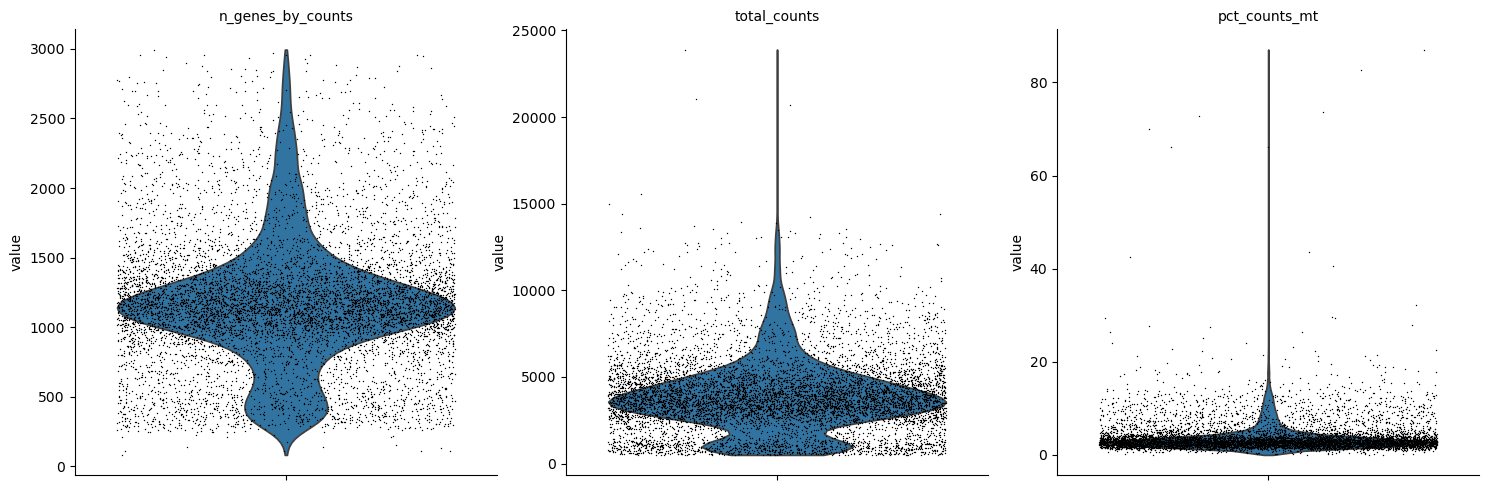

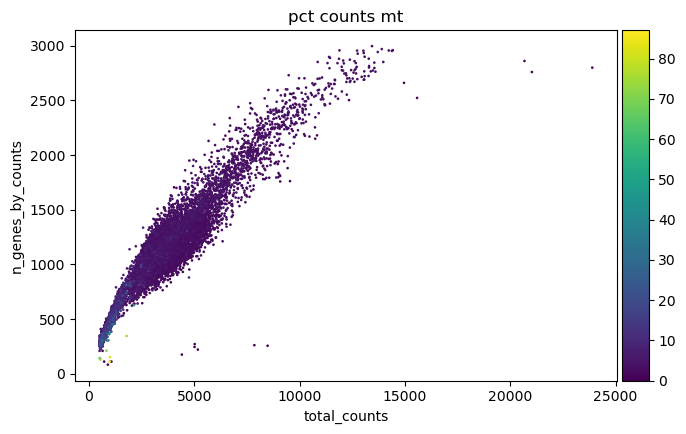

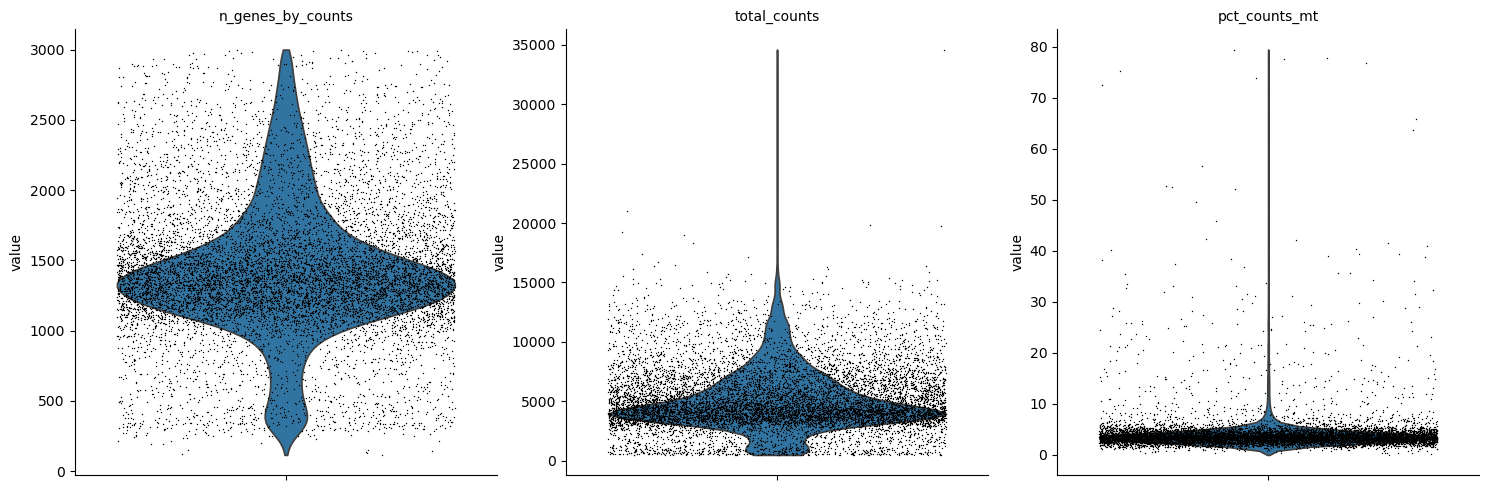

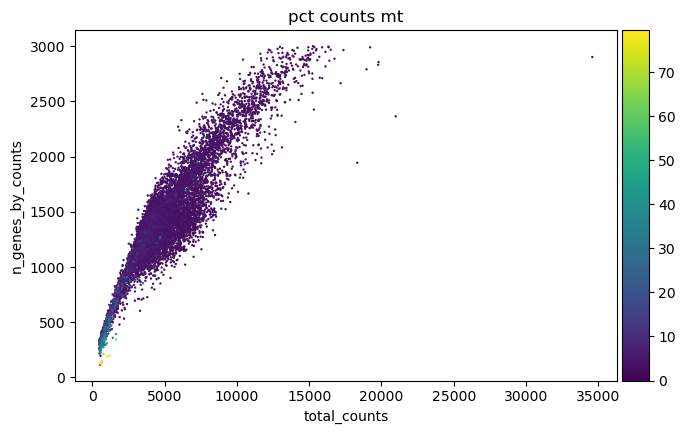

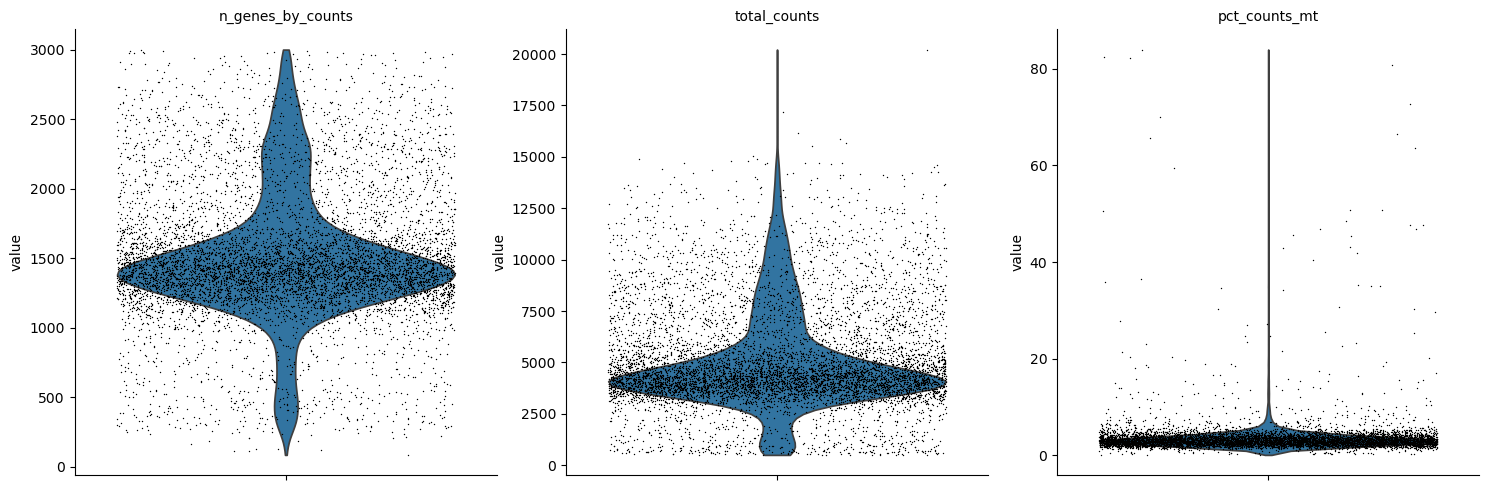

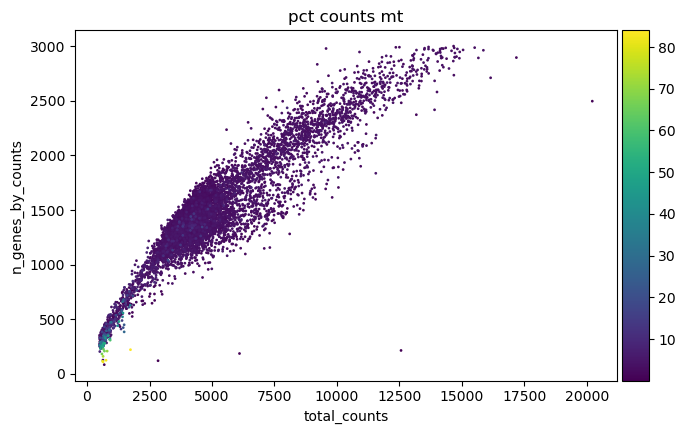

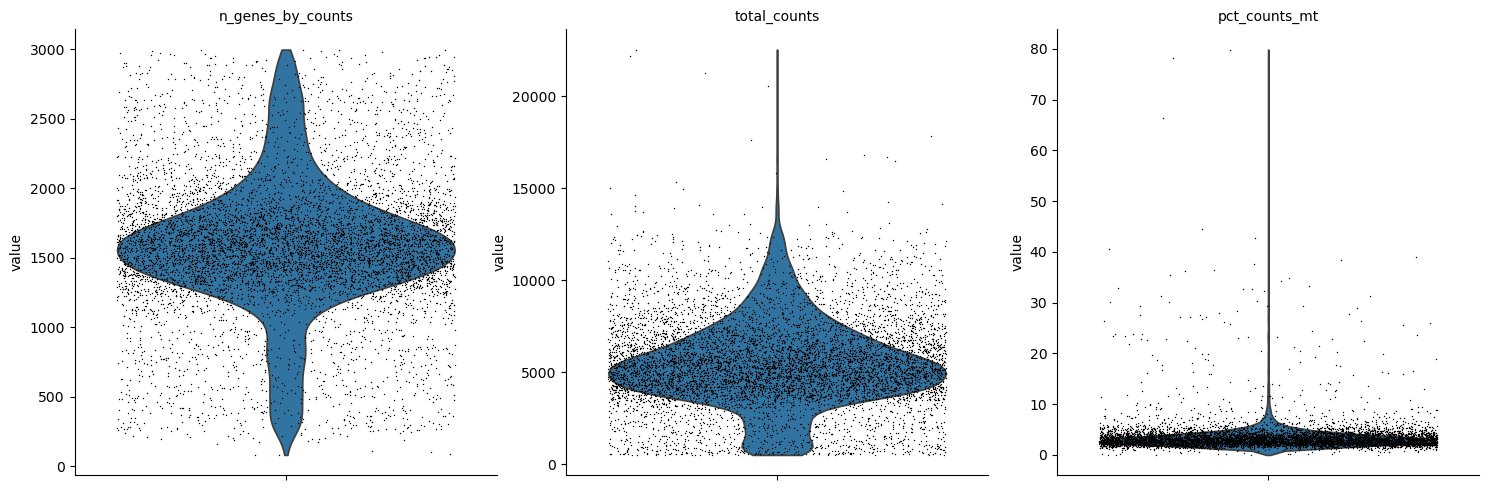

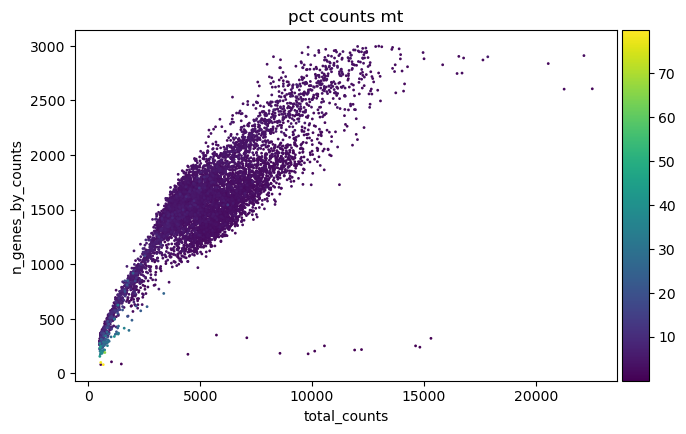

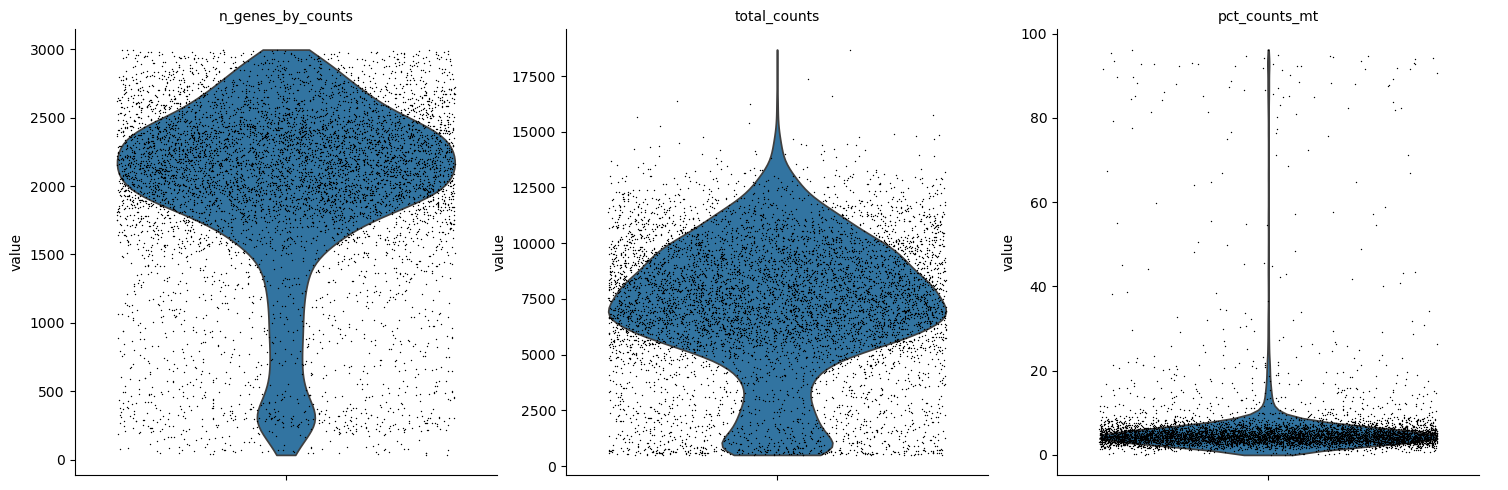

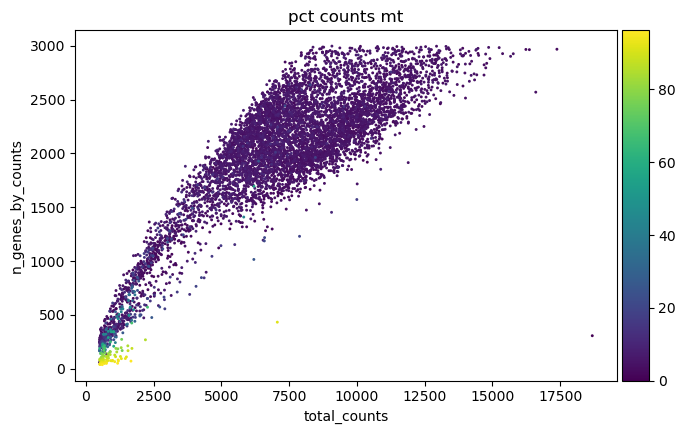

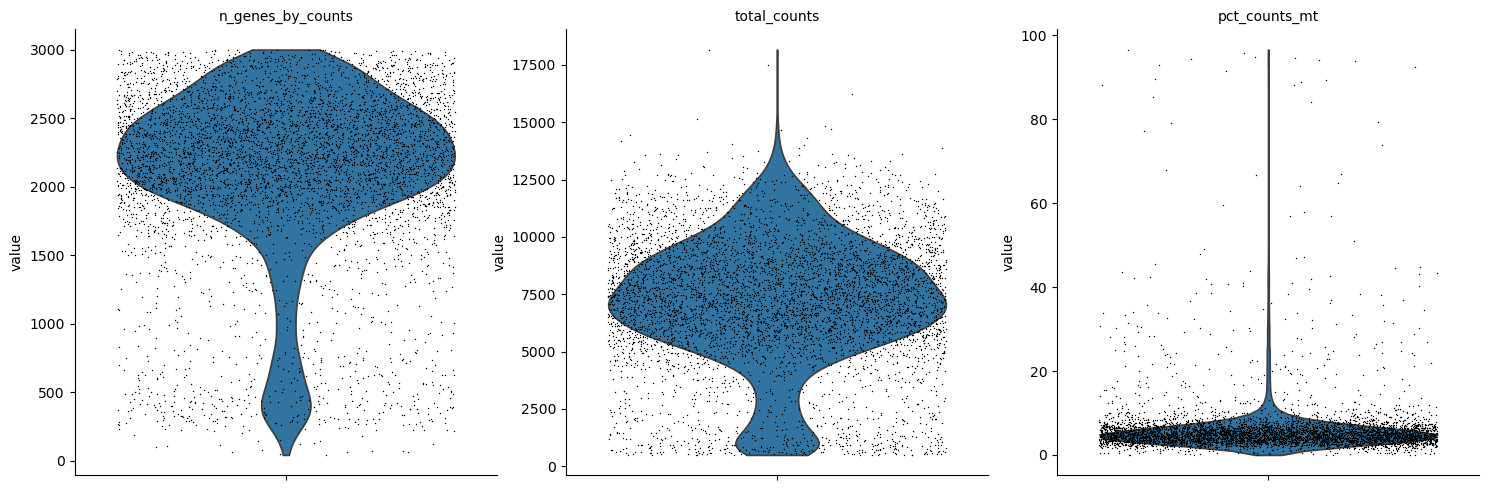

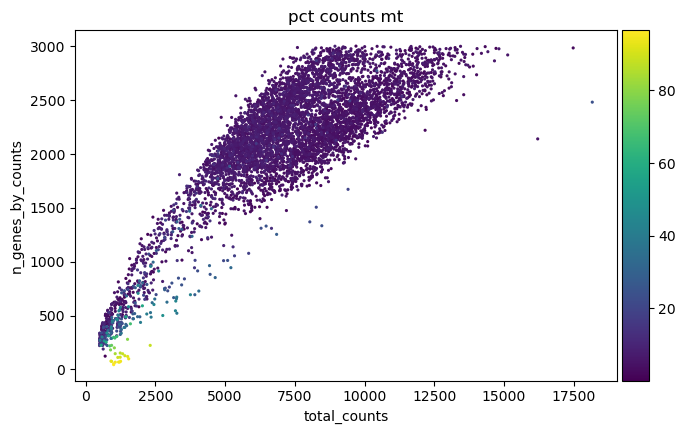

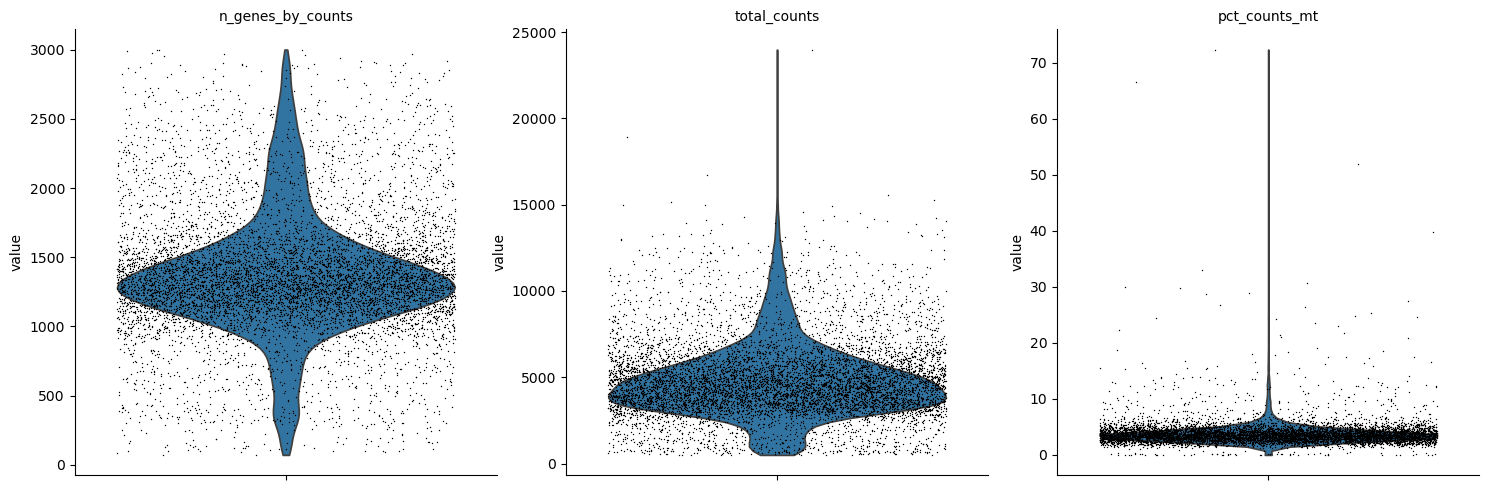

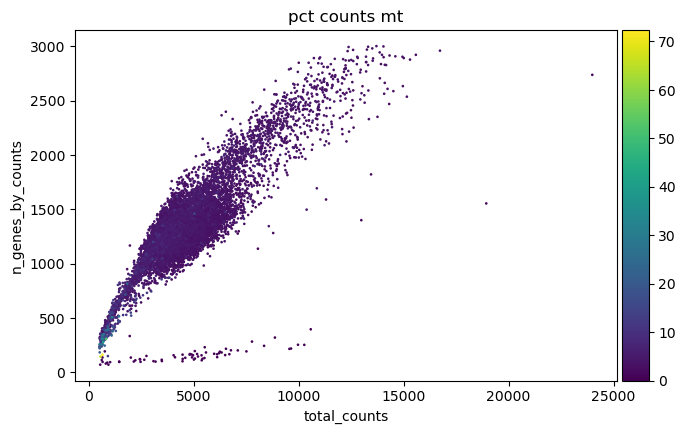

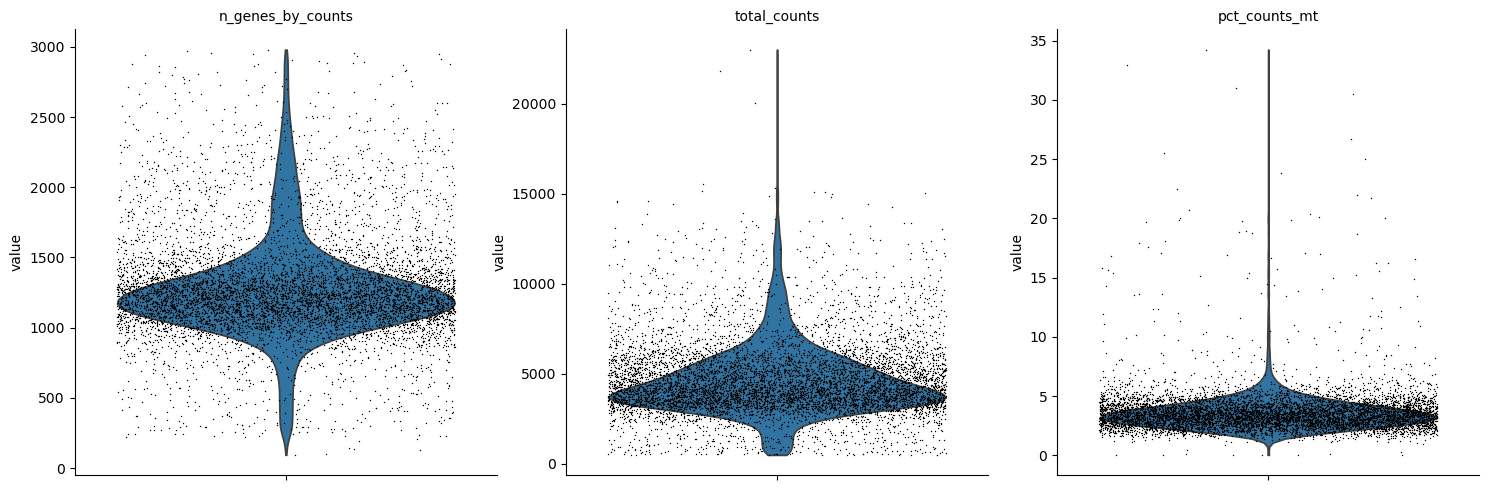

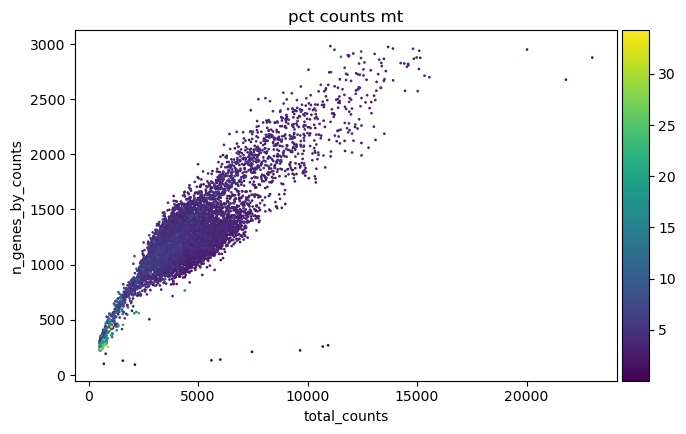

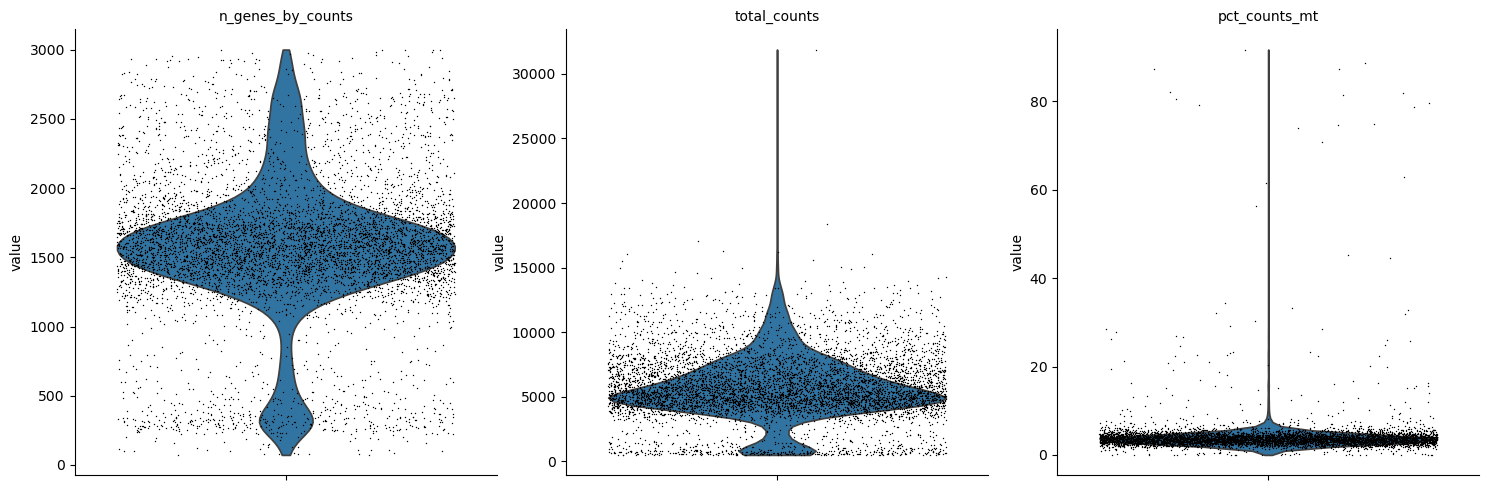

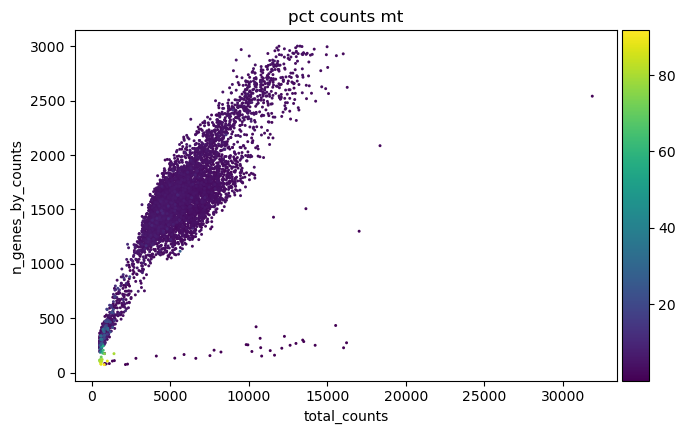

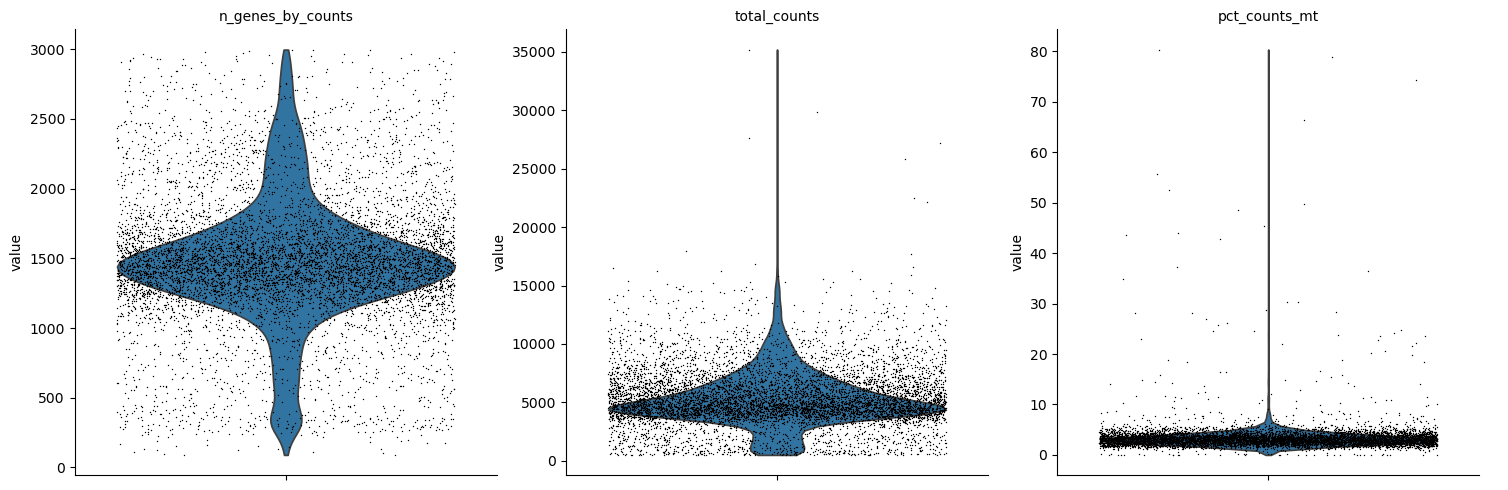

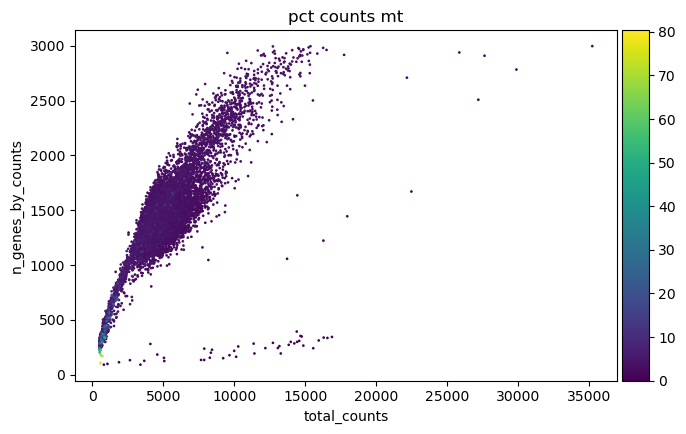

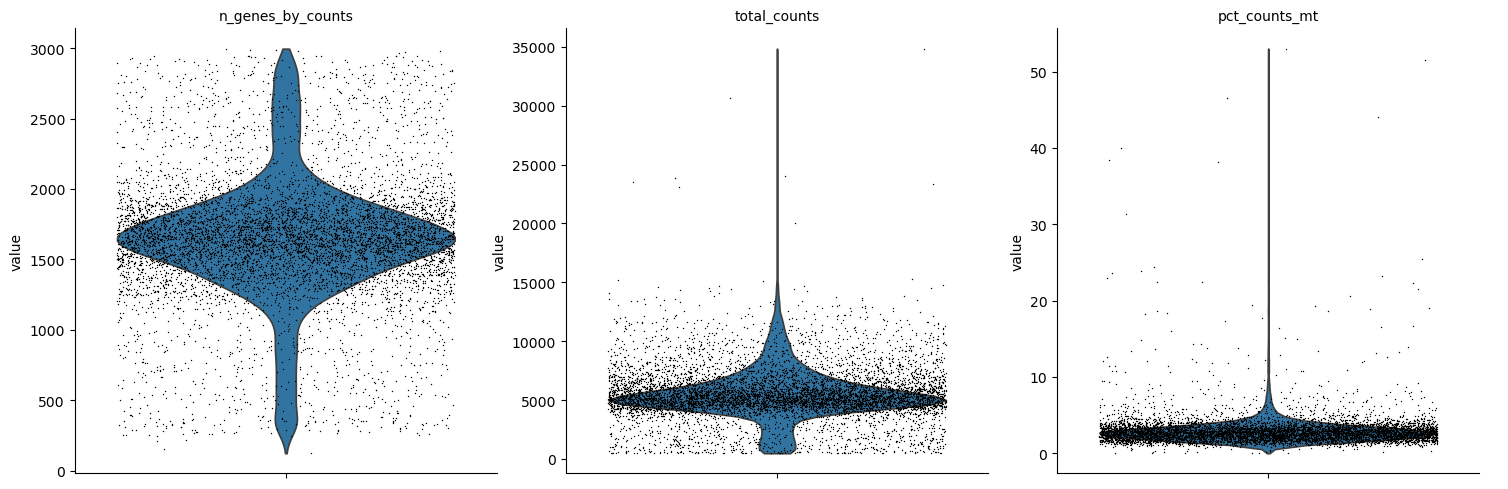

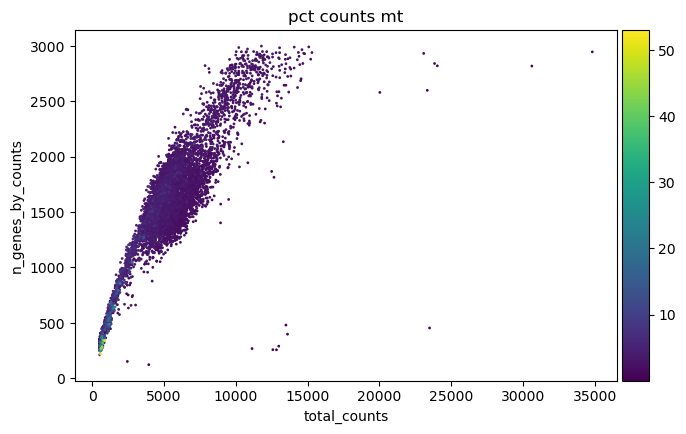

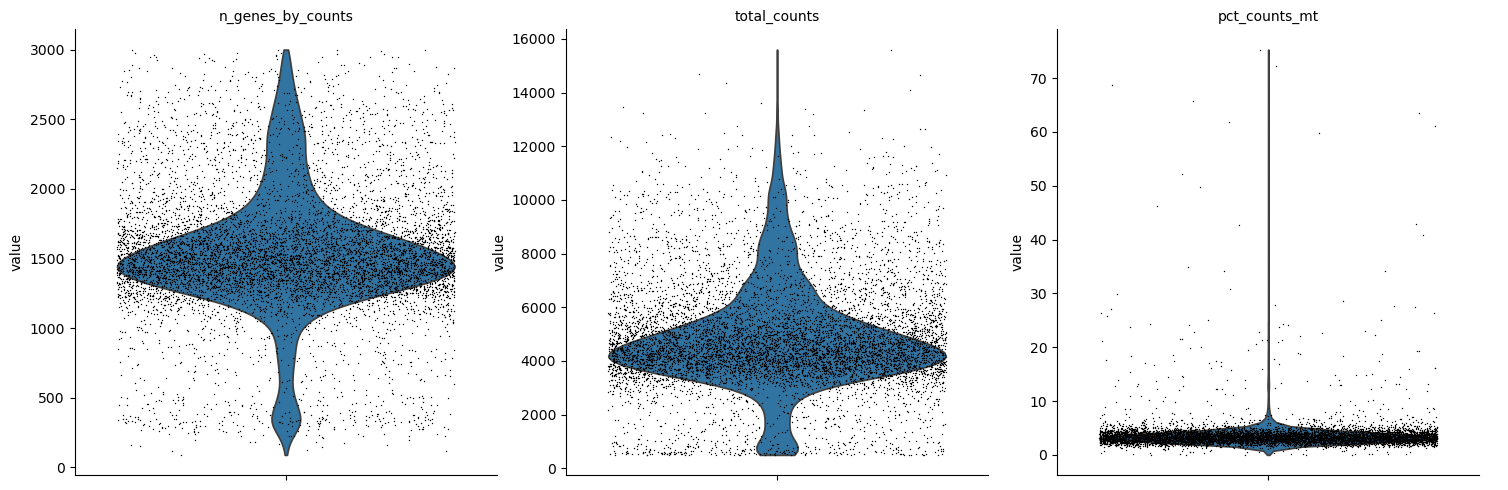

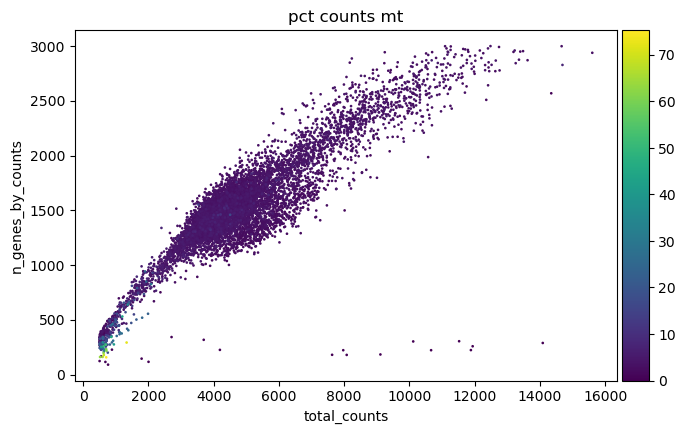

In [29]:
from anndata import AnnData
from sklearn.decomposition import PCA

filtered_adatas = {}
# Filter and annotate AnnData objects
for key, adata in adata_ls.items():
    adata.var_names_make_unique()
    adata.var['mt'] = adata.var_names.str.startswith("MT-")
    adata.var['ribo'] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var['hb'] = adata.var_names.str.contains("^HB[^(P)]")
    
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
    )

    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True,
    )

    sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

    sc.pp.filter_cells(adata, max_genes=3000)  
    
    filtered_adatas[key] = adata

In [33]:
# Concatenate filtered AnnData objects with batch labels
concatenated_adata = anndata.concat(filtered_adatas, label='sample')

/home/okwong/miniconda3/envs/ML/lib/python3.12/site-packages/anndata-0.11.0rc3-py3.12.egg/anndata/_core/anndata.py:1757: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [34]:
concatenated_adata.obs_names_make_unique()

In [35]:
sc.pp.filter_cells(concatenated_adata, min_genes=200)  

In [36]:
sc.pp.filter_genes(concatenated_adata, min_counts=20)  

In [37]:
concatenated_adata

AnnData object with n_obs × n_vars = 93016 × 18664
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample'
    var: 'n_counts'

In [39]:
print(concatenated_adata.obs.columns)

Index(['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample'],
      dtype='object')


In [43]:
sc.pp.scrublet(concatenated_adata, batch_key="sample")

In [44]:
# Normalizing to median total counts
sc.pp.normalize_total(concatenated_adata)
# Logarithmize the data
sc.pp.log1p(concatenated_adata)

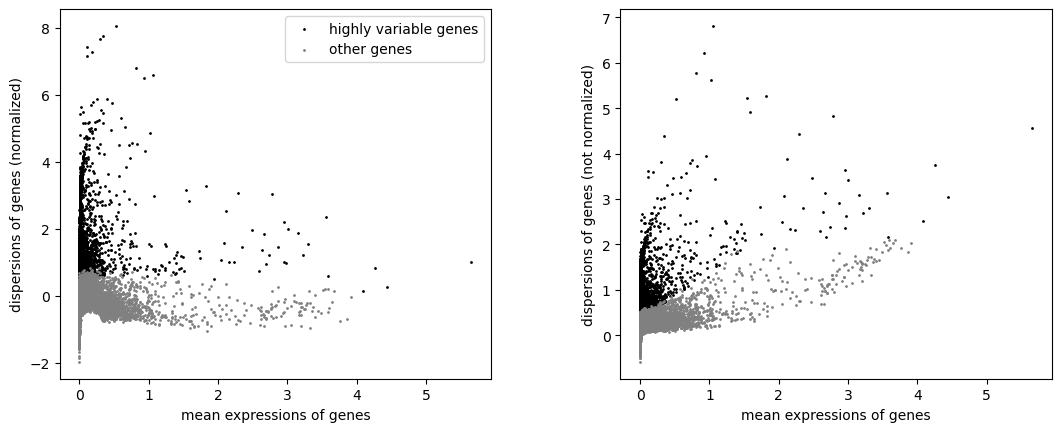

In [45]:
sc.pp.highly_variable_genes(concatenated_adata, n_top_genes=2000, batch_key='sample')
sc.pl.highly_variable_genes(concatenated_adata)

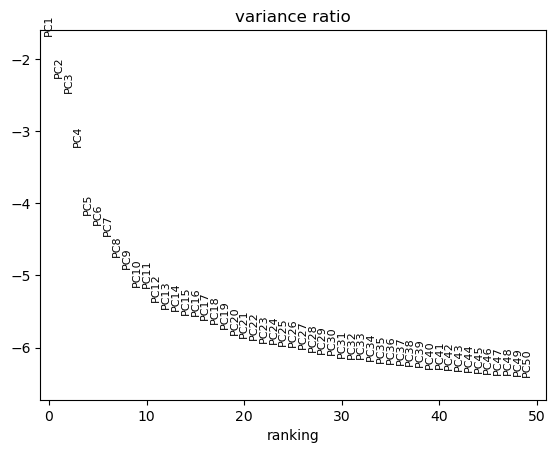

In [47]:
# Perform PCA to check for batch effects
sc.tl.pca(concatenated_adata)
sc.pl.pca_variance_ratio(concatenated_adata, n_pcs=50, log=True)

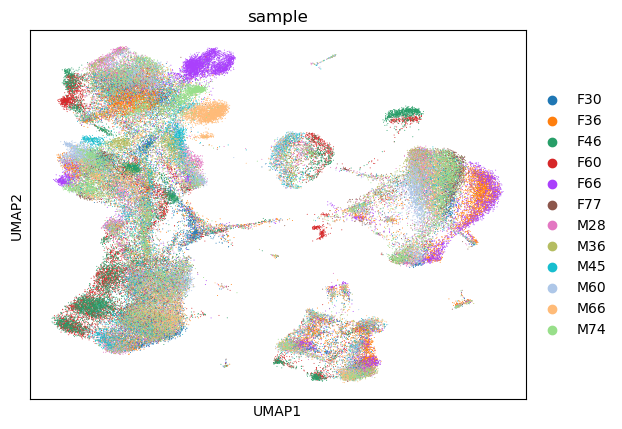

In [48]:
sc.pp.neighbors(concatenated_adata)
sc.tl.umap(concatenated_adata)
sc.pl.umap(
    concatenated_adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

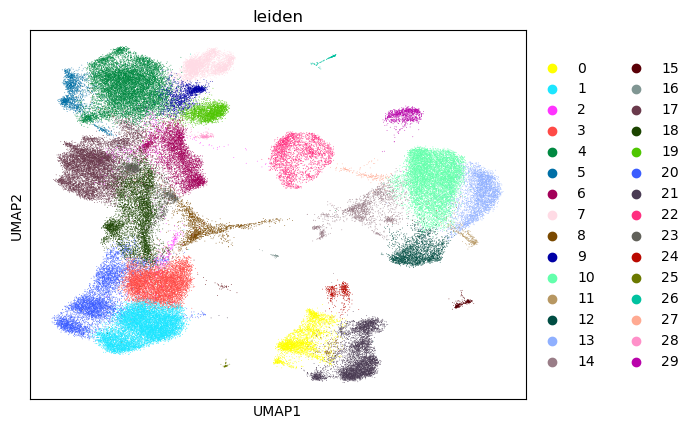

In [52]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(concatenated_adata, flavor="igraph", n_iterations=2)
sc.pl.umap(concatenated_adata, color=["leiden"])

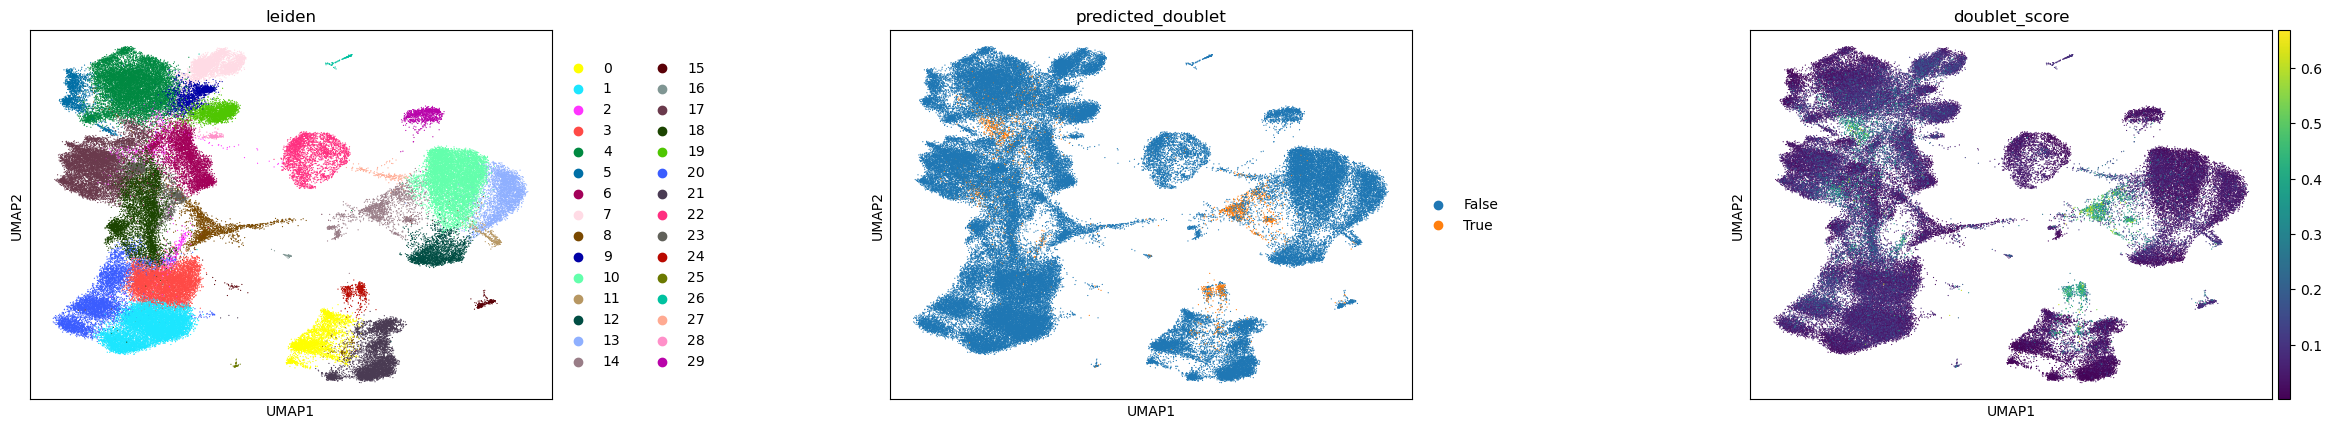

In [53]:
sc.pl.umap(
    concatenated_adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

In [ ]:
for res in [0.5, 1.0, 2.0]:
    sc.tl.leiden(
        concatenated_adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

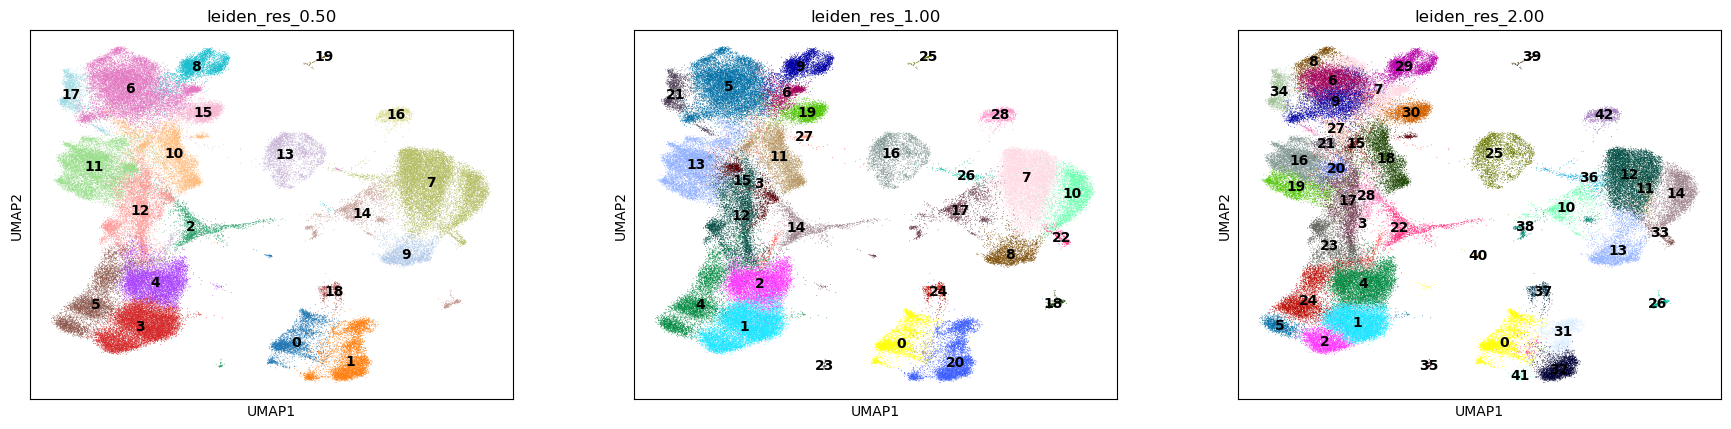

In [56]:
sc.pl.umap(
    concatenated_adata,
    color=["leiden_res_0.50", "leiden_res_1.00", "leiden_res_2.00"],
    legend_loc="on data",
)

In [57]:
for res in [0.6, 0.7, 0.8]:
    sc.tl.leiden(
        concatenated_adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

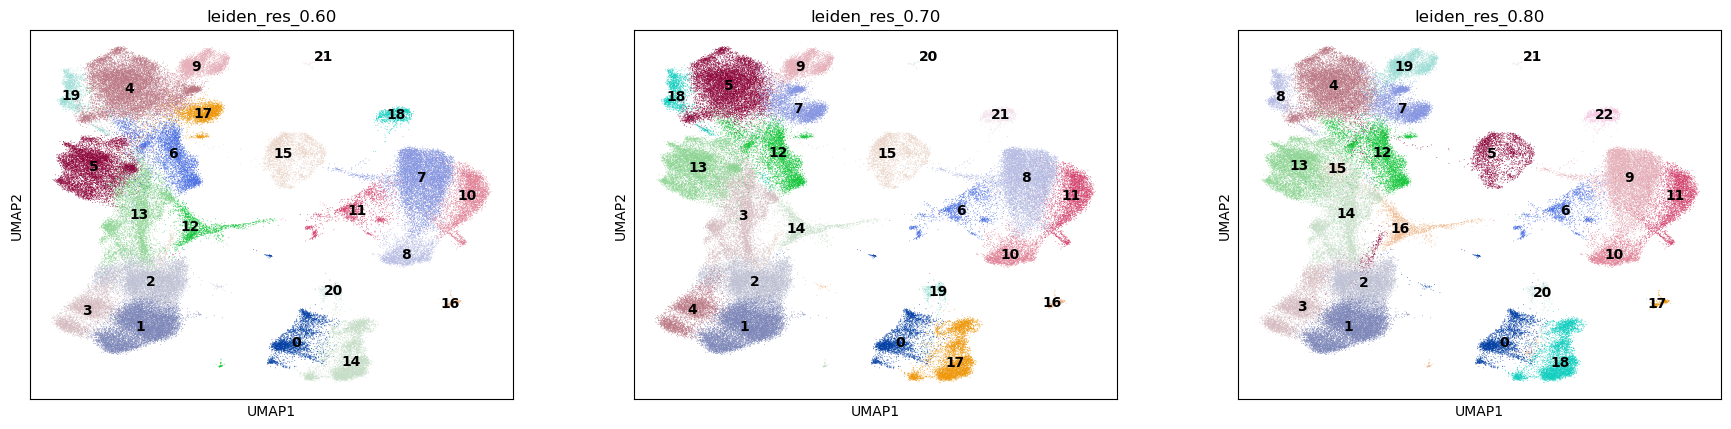

In [58]:
sc.pl.umap(
    concatenated_adata,
    color=["leiden_res_0.60", "leiden_res_0.70", "leiden_res_0.80"],
    legend_loc="on data",
)

In [59]:
concatenated_adata

AnnData object with n_obs × n_vars = 93016 × 18664
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00', 'leiden_res_0.60', 'leiden_res_0.70', 'leiden_res_0.80'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden', 'leiden_colors', 'predicted_doublet_colors', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00', 'leiden_res_0.50_colors

In [60]:
with open('/autofs/bal34/okwong/human_PBMC_ref/concatenated_adata.pkl', 'wb') as f:
    pickle.dump(concatenated_adata, f)